# MMDetection 
## Documentation: https://mmdetection.readthedocs.io/en/latest/get_started.html

# Check lib versions

In [2]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


# Setup Weights & Biases

In [3]:
# Some basic setup
import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").absolute().parent.absolute()))

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import requests
import json

def unzip(input_file:Path, output_dir=None):
    from zipfile import ZipFile
    with ZipFile(input_file,"r") as zip_ref:
         for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
              zip_ref.extract(member=file, path=output_dir)
            
def classes_from_coco(annotation_file:Path):
    with open(annotation_file) as f:
        ann = json.load(f)
    _, cfg_classes = zip(*sorted([(cat["id"], cat["name"]) for cat in ann["categories"]]))
    return cfg_classes

def mywget(url, fname, force=False):
    fname = Path(fname)
    if fname.exists() and ~force:
        print(f"File already exists. Use force=True to owerwrite.")
        return
    fname.parent.mkdir(parents=True, exist_ok=True)
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")
    

2024-02-06 16:10:22,775 - general_logger - DEBUG - mmdet.version=2.25.0
2024-02-06 16:10:22,777 - general_logger - DEBUG - 11.7
2024-02-06 16:10:22,780 - general_logger - DEBUG - GCC 9.4


1.12.0a0+8a1a93a True


In [4]:
mmdet.__version__
mmdet.__file__ # path where mmdetection is saved - use it in Jupyter notebook terminal 

'/workspace/mmdetection/mmdet/__init__.py'

# Prepare data

Download and copy dataset to scratch dir.

## Using pretrained model

In [5]:
from mmdet.apis import init_detector, inference_detector
import mmcv

mmdetection_path = Path(mmdet.__file__).parent.parent

# Specify the path to pretrained model config and checkpoint file
config = cfg
checkpoint_file = './latest.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config, checkpoint_file, device='cuda:0')

path_test_images = local_input_data_dir

filelist = list((path_test_images).glob("**/*.jpg"))
filelist.extend(list((path_test_images).glob("**/*.JPG")))
filelist.extend(list((path_test_images).glob("**/*.png")))
filelist.extend(list((path_test_images).glob("**/*.PNG")))

# TODO: use test images

results_list = []
images = []
image_filenames = []

for img_fn in random.choices(filelist, k=3):
    image_filenames.append(img_fn)
    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)
    images.append(img)
    
    model.cfg = cfg
    result = inference_detector(model, img)
    results_list.append(result)
    show_result_pyplot(model, img, result)
    # save image with result 
    model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg") 

NameError: name 'cfg' is not defined

## Extracting masks

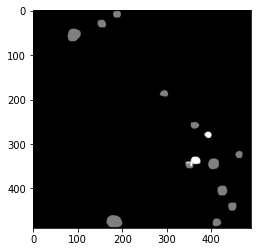

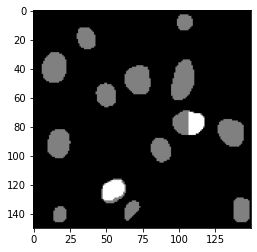

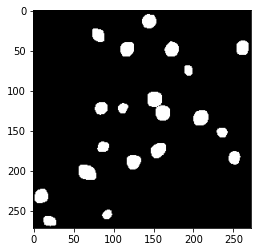

In [16]:
masks = []
for res in results_list:
    masks_list_temp = res[1]
    temp_list = []
    for i in range(len(masks_list_temp[0])):
        mask = masks_list_temp[0][i]
        # print(mask)
        temp_list.append(mask)
        # plt.imshow(mask, cmap='gray')
        # plt.show()
    plt.imshow(np.sum(temp_list, axis=0), cmap='gray')
    masks.append(np.sum(temp_list, axis=0))
    plt.show()

3


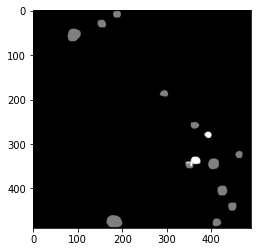

In [17]:
# Getting masks 
print(len(masks))
plt.imshow(masks[0], cmap="gray")
plt.show()

## Preparing masks (dilation)

In [18]:
from skimage.morphology import dilation

def apply_dilation(mask, num_steps_dilation):
    for i in range(num_steps_dilation):
        mask = dilation(mask)
    
    return mask

masks_dilated = []
for i in range(len(masks)):
    mask = masks[i]
    mask_dil = apply_dilation(mask, 10)
    masks_dilated.append(mask_dil)
    
    # plt.imshow(mask_dil, cmap='gray')
    # plt.show()

# plt.imshow(masks_dilated[0], cmap='gray')
# plt.show()

## Inpainting - using dilated masks

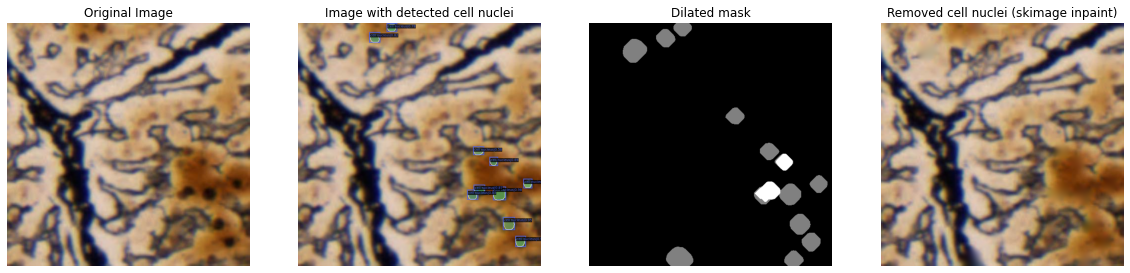

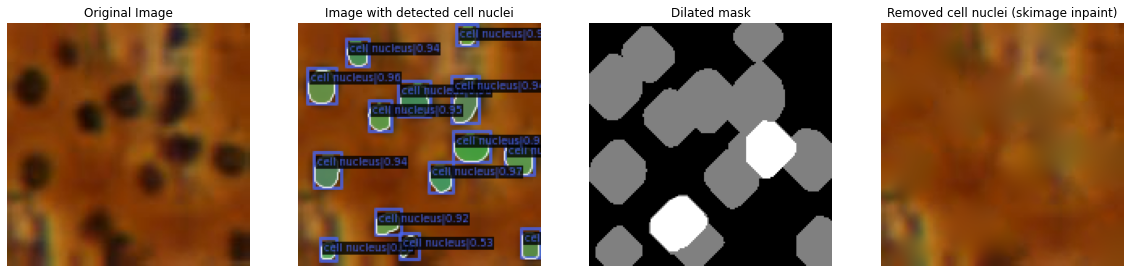

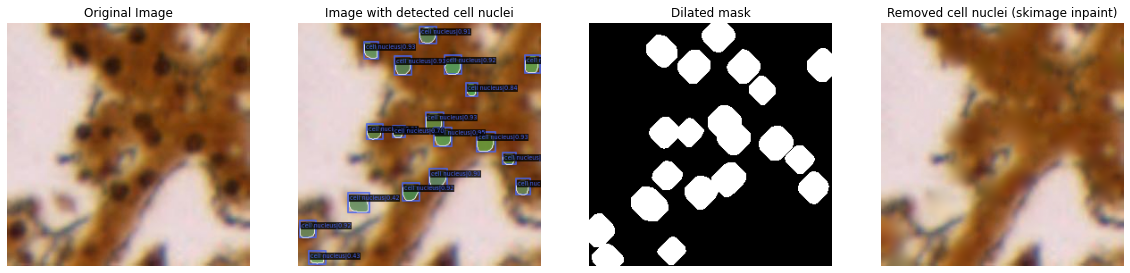

In [19]:
from skimage.restoration import inpaint

for i in range(len(images)):
    orig_img = images[i]
    img_fn = image_filenames[i]
    mask = masks_dilated[i]
    
    img = mmcv.imread(img_fn)
    model.cfg = cfg
    # print(type(mask))
    
    # Result with detected cell nuclei
    result = inference_detector(model, img)
    # show_result_pyplot(model, img, result)
    
    detected_cell_nuclei = model.show_result(img, result) 
    
    img_removed_nuclei = inpaint.inpaint_biharmonic(orig_img, mask, channel_axis=-1)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
    ax1.imshow(orig_img[:,:,::-1])
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(detected_cell_nuclei[:,:,::-1])
    ax2.set_title('Image with detected cell nuclei')
    ax2.axis('off')
    ax3.imshow(mask, cmap='gray')
    ax3.set_title('Dilated mask')
    ax3.axis('off')
    ax4.imshow(img_removed_nuclei[:,:,::-1])
    ax4.set_title('Removed cell nuclei (skimage inpaint)')
    ax4.axis('off')
    plt.show()
    

## Trying own inpainting

In [20]:
# img_new = img.copy()
# reds = img[:,:,2][masks_diff == 1] # seznam pixelu okolo masky, barvy ktere se objevily kolem masek 
# greens = img[:,:,1][masks_diff == 1]
# blues = img[:,:,0][masks_diff == 1]

# mean_color = [np.mean(blues), np.mean(greens), np.mean(reds)] # prumerna barva
# mean_color = np.mean(np.mean(img, axis = 1), axis = 0)
# mean_color

In [21]:
# img_new[masks > 0] = mean_color
# # img_new[masks > 0] = [0,0,0]
# plt.imshow(img_new[:,:,::-1])
# plt.show()

# plt.imshow((0.7 * img_new + 0.3 * img).astype(int)[:,:,::-1])
# plt.show()

In [22]:
# # Blur image using Gaussian filter
# gau_img = skimage.filters.gaussian(img[:,:,::-1], sigma=100, truncate=1/5) # How to define sigma parameter based on the image? 

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# ax1.imshow(img[:,:,::-1])
# ax1.set_title('Original Image')
# ax1.axis('off')
# ax2.imshow(gau_img)
# ax2.set_title('Filtered Image (Gaussian)')
# ax2.axis('off')

# mean_color_2 = np.mean(np.array(gau_img), axis=(0, 1)) # BGR
# mean_color_2 = np.array([mean_color_2[2], mean_color_2[1], mean_color_2[0]]) # RGB
# print("RGB mean color: " + str(mean_color_2 * 255))


# img_new_2 = img.copy()
# img_new_2[masks > 0] = mean_color_2 * 255
# # img_new[masks > 0] = [0,0,0]
# ax3.imshow(img_new_2[:,:,::-1])
# ax3.set_title('Result')
# ax3.axis('off')
# plt.show()

In [23]:
# # Dividing image into 4 quarters
# height, width, channel = gau_img.shape

# mean_color_1_quarter = np.mean(np.array(gau_img[0:height//2, 0:width//2, :]), axis=(0, 1)) # BGR
# mean_color_1_quarter = np.array([mean_color_1_quarter[2], mean_color_1_quarter[1], mean_color_1_quarter[0]]) # RGB

# mean_color_2_quarter = np.mean(np.array(gau_img[0:height//2, width//2::, :]), axis=(0, 1)) # BGR
# mean_color_2_quarter = np.array([mean_color_2_quarter[2], mean_color_2_quarter[1], mean_color_2_quarter[0]]) # RGB

# mean_color_3_quarter = np.mean(np.array(gau_img[height//2::, 0:width//2, :]), axis=(0, 1)) # BGR
# mean_color_3_quarter = np.array([mean_color_3_quarter[2], mean_color_3_quarter[1], mean_color_3_quarter[0]]) # RGB

# mean_color_4_quarter = np.mean(np.array(gau_img[height//2::, width//2::, :]), axis=(0, 1)) # BGR
# mean_color_4_quarter = np.array([mean_color_4_quarter[2], mean_color_4_quarter[1], mean_color_4_quarter[0]]) # RGB


# print(mean_color_1_quarter * 255)
# print(mean_color_2_quarter * 255)
# print(mean_color_3_quarter * 255)
# print(mean_color_4_quarter * 255)

# img_new_3 = img.copy()
# img_new_3[masks > 0] = mean_color_1_quarter * 255
# # img_new[masks > 0] = [0,0,0]
# plt.imshow(img_new_3[:,:,::-1])
# plt.axis('off')
# plt.show()


In [24]:
# # https://docs.opencv.org/3.4/df/d3d/tutorial_py_inpainting.html
# import cv2
# image_inpainted_NS = cv2.inpaint(img, masks.astype('uint8'), 5, cv2.INPAINT_NS)
# image_inpainted_TELEA = cv2.inpaint(img, masks.astype('uint8'), 5, cv2.INPAINT_TELEA)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# ax1.imshow(img[:,:,::-1])
# ax1.set_title('Original Image')
# ax1.axis('off')
# ax2.imshow(image_inpainted_NS[:,:,::-1])
# ax2.set_title('Removed cell nuclei (cv2 inpaint - NS)')
# ax2.axis('off')
# ax3.imshow(image_inpainted_TELEA[:,:,::-1])
# ax3.set_title('Removed cell nuclei (cv2 inpaint - TELEA)')
# ax3.axis('off')

In [25]:
# # https://scikit-image.org/docs/stable/auto_examples/filters/plot_inpaint.html
# from skimage.restoration import inpaint
# img_black_cell = img.copy()
# img_black_cell[masks > 0] = np.array([0, 0, 0])


# masks_cp = masks.copy().astype('bool')
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = dilation(masks_cp)
# masks_cp = apply_dilation(masks_cp, 10)
# # masks_cp = cv2.subtract(255, masks_cp)
# image_result_2 = inpaint.inpaint_biharmonic(img_black_cell, masks_cp, channel_axis=-1)


# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
# ax1.imshow(img[:,:,::-1])
# ax1.set_title('Original Image')
# ax1.axis('off')
# ax2.imshow(img_black_cell[:,:,::-1])
# ax2.set_title('Black cell nuclei')
# ax2.axis('off')
# ax3.imshow(image_result_2[:,:,::-1])
# ax3.set_title('Removed cell nuclei (skimage inpaint)')
# ax3.axis('off')
# ax4.imshow(masks_cp, cmap='gray')
# ax4.set_title('Mask')
# ax4.axis('off')
# plt.show()

# print(type(img))
# print(img.dtype)
# print(masks_cp.dtype)
# print(img_black_cell.dtype)
# # plt.imsave("orig_image.jpg", img[:,:,::-1])
# # plt.imsave("mask.jpg", img_black_cell[:,:,::-1])

In [26]:
# https://www.nvidia.com/research/inpainting/

## Application - removing cell nuclei

In [27]:
# def get_num_cols_rows(img: np.array, small_image_size_px: int):
#     rows = (img.shape[0] // small_image_size_px) + 1
#     cols = (img.shape[1] // small_image_size_px) + 1

#     return (rows, cols)

# def divide_image(img: np.array, small_image_size_px):
#     orig_image_size = (img.shape[0], img.shape[1])
#     (num_rows, num_cols) = get_num_cols_rows(img, small_image_size_px)

#     divided_images = []

#     for i in range(num_rows):
#         for j in range(num_cols):

#             new_row_start = i * small_image_size_px
#             new_row_end = (i + 1) * small_image_size_px

#             new_col_start = j * small_image_size_px
#             new_col_end = (j + 1) * small_image_size_px

#             small_image = img[new_row_start:new_row_end, new_col_start:new_col_end]
#             divided_images.append(small_image)

#     return [divided_images, orig_image_size]


# def merge_image(divided_images: list, small_image_size_px, orig_image_size: tuple, orig_img):
#     merged_image = np.zeros((orig_image_size[0], orig_image_size[1], 3), dtype="uint8")
#     (num_rows, num_cols) = get_num_cols_rows(orig_img, small_image_size_px)

#     for i in range(num_rows):
#         for j in range(num_cols):
#             idx = i * num_cols + j
            
#             row_start = i * small_image_size_px
#             row_end = (i + 1) * small_image_size_px
            
#             col_start = j * small_image_size_px
#             col_end = (j + 1) * small_image_size_px
            
#             merged_image[row_start:row_end, col_start:col_end] = divided_images[idx]
    
#     print(merged_image)

#     return merged_image


# def divide_image_iterator(img: np.array, small_image_size_px):
#     orig_image_size = (img.shape[0], img.shape[1])
#     (num_rows, num_cols) = get_num_cols_rows(img, small_image_size_px)

#     divided_images = []

#     for i in range(num_rows):
#         for j in range(num_cols):

#             new_row_start = i * small_image_size_px
#             new_row_end = (i + 1) * small_image_size_px

#             new_col_start = j * small_image_size_px
#             new_col_end = (j + 1) * small_image_size_px

#             small_image = img[new_row_start:new_row_end, new_col_start:new_col_end]
#             # divided_images.append(small_image)
#             yield small_image

#     # return [divided_images, orig_image_size]

In [28]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [43]:
import numpy as np
import cv2
import os
from pathlib import Path
from matplotlib import pyplot as plt
import tqdm


class ImageSplitterMerger(object):
    """Class which represents splitter and merger of the image"""
    def __init__(self, img_array: np.array, tilesize_px: int, padding_px: int):
        self.img_array = img_array
        self.tilesize_px = tilesize_px
        self.padding_px = padding_px

    def get_num_cols_rows(self):
        img = self.img_array
        tilesize_px = self.tilesize_px
        padding_px = self.padding_px

        num_rows = int(np.ceil(img.shape[0] / (tilesize_px - padding_px)))
        num_cols = int(np.ceil(img.shape[1] / (tilesize_px - padding_px)))

        return num_rows, num_cols

    def get_number_tiles(self):
        nx, ny = self.get_num_cols_rows()
        return nx * ny

    def split_iterator(self):
        """Split image into tiles."""
        img = self.img_array
        tilesize_px = self.tilesize_px
        padding_px = self.padding_px

        (num_rows, num_cols) = self.get_num_cols_rows()

        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * (tilesize_px - padding_px)
                row_end = row_start + tilesize_px

                col_start = j * (tilesize_px - padding_px)
                col_end = col_start + tilesize_px

                # New padded tile for each iteration
                dimension = img.shape[2]
                padded_tile = np.zeros((tilesize_px + 2 * padding_px, tilesize_px + 2 * padding_px, dimension),
                                       dtype="uint8")

                padded_tile = self.get_padded_tile(col_end, col_start, img, padded_tile, padding_px, row_end, row_start)
                tile_image_object = ImageTile(padded_tile)

                # plt.imshow(padded_tile)
                # plt.show()
                yield tile_image_object

    def get_padded_tile(self, col_end: int, col_start: int, img: np.array, padded_tile: np.array, padding_px: int, row_end: int, row_start: int):
        """Returns padded tile."""
        # Calculate the valid region to copy from the original image
        img_row_start = max(0, row_start - padding_px)
        img_row_end = min(img.shape[0], row_end + padding_px)
        img_col_start = max(0, col_start - padding_px)
        img_col_end = min(img.shape[1], col_end + padding_px)

        # Calculate the corresponding region in the padded tile
        pad_row_start = max(0, padding_px - (row_start - img_row_start))
        pad_row_end = pad_row_start + img_row_end - img_row_start
        pad_col_start = max(0, padding_px - (col_start - img_col_start))
        pad_col_end = pad_col_start + img_col_end - img_col_start

        # Copy the valid region from the original image to the padded tile
        padded_tile[pad_row_start:pad_row_end, pad_col_start:pad_col_end] = img[img_row_start:img_row_end,
                                                                            img_col_start:img_col_end]

        return padded_tile

    def merge_tiles_to_image(self, tiles: list):
        """Merge tiles into image and remove padding."""
        orig_image = self.img_array
        tilesize_px = self.tilesize_px
        padding_px = self.padding_px
        (num_rows, num_cols) = self.get_num_cols_rows()

        # Initialize the merged image
        merged_image = np.zeros(orig_image.shape, dtype="uint8")

        with tqdm.tqdm(total=num_rows * num_cols, desc="Merging Tiles") as pbar:
            for i in range(num_rows):
                for j in range(num_cols):
                    idx = i * num_cols + j

                    row_start = i * (tilesize_px - padding_px)
                    row_end = min(row_start + tilesize_px, merged_image.shape[0])  # Adjust for edge tiles

                    col_start = j * (tilesize_px - padding_px)
                    col_end = min(col_start + tilesize_px, merged_image.shape[1])  # Adjust for edge tiles

                    # Remove padding from all sides of the tile
                    tile_no_padding = tiles[idx][padding_px:(padding_px + row_end - row_start),
                                                      padding_px:(padding_px + col_end - col_start)] # TODO: tiles[idx] as object? 

                    # plt.imshow(tile_no_padding)
                    # plt.show()

                    # Calculate the corresponding region in the merged image
                    merged_row_start = i * (tilesize_px - padding_px)
                    merged_row_end = merged_row_start + row_end - row_start
                    merged_col_start = j * (tilesize_px - padding_px)
                    merged_col_end = merged_col_start + col_end - col_start

                    # Copy the tile without padding to the merged image
                    merged_image[merged_row_start:merged_row_end, merged_col_start:merged_col_end] = tile_no_padding
                    pbar.update(1)

        return merged_image

    def split_and_merge_image(self, process_tile_bool: bool):
        """Split and merge image, process tile."""
        processed_tiles = []
        total_tiles = self.get_number_tiles()

        for tile in tqdm.tqdm(self.split_iterator(), total=total_tiles, desc="Splitting and Processing Tiles"):
            if process_tile_bool:
                processed_tile = tile.process_tile(process_tile_bool)
            else:
                processed_tile = tile
                
            processed_tiles.append(processed_tile)

        merged_img = self.merge_tiles_to_image(processed_tiles)

        return merged_img

In [44]:
from skimage.morphology import dilation
from skimage.restoration import inpaint

class ImageTile(object):
    """Class which represents image tile."""
    def __init__(self, tile: np.array):
        self.tile = tile

    def process_tile(self):
        tile_removed_cell_nuclei = self.remove_cell_nuclei(self.tile)
        
        return tile_removed_cell_nuclei

    def remove_cell_nuclei(self, tile: np.array) -> np.array:
        res_inference = self.do_inference(tile)
        mask = self.create_mask_from_inferences(res_inference)
        # print(type(mask))
        tile_removed_cell_nuclei = None
        if mask is not None:  # mask in tile
            mask_dil = self.apply_dilation(mask, 10)
            img_removed_cell_nuclei = self.do_inpainting(tile, mask_dil)
            tile_removed_cell_nuclei = img_removed_cell_nuclei * 255

            return tile_removed_cell_nuclei

        else: # no mask in tile; returning the original tile
            return tile
        
    
    def do_inference(self, tile):
        model.cfg = cfg
        result = inference_detector(model, tile[:,:,::-1])
        # results_list.append(result)
        # show_result_pyplot(model, img, result) 
        # model.show_result(img, result) 

        return result
    
    def create_mask_from_inferences(self, inferences: list):
        masks = []

        # for inference in inferences:
        masks_list_temp = inferences[1]
        temp_list = []

        if masks_list_temp[0] is not None:
            for i in range(len(masks_list_temp[0])):
                mask = masks_list_temp[0][i]
                # print(mask)
                temp_list.append(mask)
                # plt.imshow(mask, cmap='gray')
                # plt.show()
            if len(temp_list) > 0:
                # plt.imshow(np.sum(temp_list, axis=0), cmap='gray')
                # plt.show()

                mask = np.sum(temp_list, axis=0)

                return mask
        else:
            return None
        
        
    def apply_dilation(self, mask, num_steps_dilation):
        for i in range(num_steps_dilation):
            mask = dilation(mask)

        return mask
    
    def do_inpainting(self, orig_tile: np.array, mask):
        img_removed_nuclei = inpaint.inpaint_biharmonic(orig_tile, mask, channel_axis=-1)
        # plt.imshow(img_removed_nuclei[:,:,::-1])
        # plt.show()

        return img_removed_nuclei
    

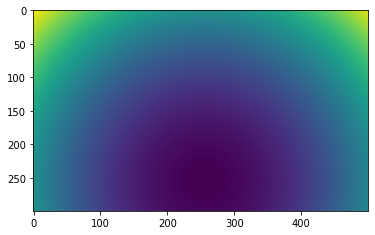

In [45]:
import numpy as np
import matplotlib.pyplot as plt

x, y = np.indices([300, 500])
center1 = (256, 256)
radius1 = 20
mask = (x - center1[0])**2 + (y - center1[1])**2

plt.imshow(mask)
plt.show()

## Usage of the classes and methods 

In [ ]:
from pathlib import Path

img_path = Path('J7_5_a.png')
# img_path = Path('orig_image.jpg')

img_array = mmcv.imread(img_path)
image = ImageSplitterMerger(img_array, tilesize_px = 100, padding_px = 10)
merged_image = image.split_and_merge_image(process_tile_bool = True)

import skimage.io
skimage.io.imsave("res.png", merged_image[:,:,::-1])

# Save the data

In [ ]:
for img_fn in filelist:

    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img) # dulezita promenna na ziskani informaci o detekci/segmentaci # TODO: zjistit, co znamenaji cisla v promenne result
    # show_result_pyplot(model, img, result)
    # save image with result 
    model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg")  

In [ ]:
# Promenna result - ziskani masek, pripadne bounding boxu 
# result

# Copy data to my home

In [ ]:
# dtstr = datetime.now().strftime("%Y%m%d_%H%M")
# # dtstr = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# !mkdir -p ~/data/processed/$dtstr

# output_path = str(Path("~/data/processed").expanduser() / dtstr)
# input_path = str(scratchdir/"data/processed/")

# !cp -r "$SCRATCHDIR"/data/processed/* {output_path} 
# !ls ~/data/processed/$dtstr
# print(dtstr)
# print(input_path)
# print(output_path)

In [ ]:
import shutil, errno

def copy_files(src, dst):
    try:
        shutil.copytree(src, dst)
    except OSError as exc: # python >2.5
        if exc.errno in (errno.ENOTDIR, errno.EINVAL):
            shutil.copy(src, dst)
        else: raise
        
dtstr = datetime.now().strftime("%Y%m%d_%H%M")
# dtstr = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

input_path = str(scratchdir/"data/processed/")
output_path = str(Path("~/data/processed").expanduser() / dtstr)
        
copy_files(input_path, output_path)
!ls ~/data/processed/$dtstr

In [ ]:
%tensorboard --logdir /scratch/jburian/job_14521657.meta-pbs.metacentrum.cz/data/processed/tutorial_exps